$$ \text{Twitter Moral Corpus} $$
$$ \text{and} $$
$$ \text{H2O's Python Client with Driverless AI} $$

This notebook utilizes H2O's Driverless AI and related Python Client to analyze the Twitter Corpus Paper 'Moral Foundations Twitter Corpus: A collection of 35k tweets annotated for moralsentiment.' The goal is to analyze the Twitter Moral Corpus and test the efficacy and usability of H2O's automated machine learning through their H2O Ai Client.  

Moral Foundations Theory is a five factor taxonomy of human morality. Below are the five.

Moral Factors:
- Care\Harm
- Fairness\Cheating
- Loyalty\Betrayal
- Authority\Subversion
- Purity\Degradation

Import libraries -- 

In [195]:
import os
import time
import datetime
import wget #!pip install wget
import subprocess
import numpy as np #
import pandas as pd
from zipfile import ZipFile 
from h2oai_client import Client
from sklearn import model_selection

# pd.set_option('display.max_rows', None), 
pd.set_option('display.max_columns', None)

Download twitter data with tweets.

In [2]:
# wget.download('https://drive.google.com/u/0/uc?id=1d1p95CspLTT1em4I42rDpWY6Hcikg296&export=download')

optional - if you downloaded the data from above. -- 

The twitter data doesn't come with tweets. In order to get the tweets you have to sign up for a twitter develop account. 

You will need to collect the following and fill in the values in the text_script before you run it with python text_script.py. The tweets will then be populated. <br>
Values to be filled: consumer_key='', consumer_secret='', access_token_key='', access_token_secret=''

In [3]:
# Twitter sentiment data
# wget.download('https://osf.io/cwu4m/download')
# os.rename('MFTC_V4.json', 'twitter_sentiment.json')

# Text script
# wget.download('https://osf.io/mzg5w/download')
# !python text_scripts

didn't download -- 

The davidson comes separate. Below will download that; however, this was left out because the word classications weren't available. 

In [4]:
# Wget for Davidson dataset mentioned below
# wget.download('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/ \
# master/data/labeled_data.csv')
# df_davidson = pd.read_csv('labeled_data.csv').drop(columns=['Unnamed: 0'])

load driverlessai credentials -- 

Set credentials for H2O Client. The username will be the beginning of the email used for your GCP account. You can also type ‘id’ into the terminal and that will show the username, i.e. uid=1001(username). 

In [5]:
address = 'http://34.71.197.74:12345'
username = 'datasciprojects'
password = 'Cypher65'
h2oai = Client(address = address, username = username, password = password)

Place corpus' in dataframes. -- 

Import moral corpus', below is each given corpus. The Davidson corpus needed to be downloaded from elsewhere, and didn't have the actual classification words included so was ultimately excluded from the analysis.  

Domains are selected based on relevant moral problems in social sciences.
- ALM: All Lives Matter - political right
- Baltimore: Baltimore protests related to the death of Freddie Gray.
- BLM: Black Lives Matter - political left
- Election: The 2016 presidential election
- MeToo: Womens sexual harassment/assualt movement. 
- Sandy: Hurricane Sandy
- Davidson: Hate Speech

In [6]:
df = pd.read_json('tw.json')
dfs = []
ALM, Baltimore, BLM, Election, MeToo, Sandy = df['Tweets'][0], df['Tweets'][1], df['Tweets'][2], \
                                              df['Tweets'][4], df['Tweets'][5], df['Tweets'][6]

corpus = [ALM, Baltimore, BLM, Election, MeToo, Sandy]

clean data --

The domains come embedded in a json file. For ease of use, the below code takes the json and places it in a pandas dataframe. All hash tags were removed from the tweets. Each tweet has the potential to have multiple word classifications based on the aforementioned moral theory factors.  

In [7]:
# Initial lists to be converted to a dataframe later
text_id = []
tweet = []
date = []
annotation = []

for c in corpus:
    for i in c:
        text_id.append(list(i.values())[0])
        tweet.append(list(i.values())[1])
        date.append(list(i.values())[2])
        annotation.append(list(i.values())[3])

tweet = pd.DataFrame(tweet, columns=['tweet'])
text_id = pd.DataFrame(text_id, columns=['text_id'])
date = pd.DataFrame(date, columns=['date'])

frst_column_annotations = []
scnd_column_annotations = []


for i in annotation:
    frst_column_annotations.append(list(i[0].values())[1])
    scnd_column_annotations.append(list(i[1].values())[1])

dataframe_a_words = pd.DataFrame(frst_column_annotations, columns=['word1'])
dataframe_b_words = pd.DataFrame(scnd_column_annotations, columns=['word2'])
words = pd.concat([dataframe_a_words, dataframe_b_words], axis=1)

words_col_a = words['word1'].str.split(',', 4, expand=True).rename(columns={0:'w1', 1:'w2', 2:'w3', 3:'w4', 4:'w5'})
words_col_b = words['word2'].str.split(',', 5, expand=True).rename(columns={0:'w6', 1:'w7', 2:'w8', 3:'w9', 4:'w10', 5:'w11'})
words_df = pd.concat([words_col_a, words_col_b], axis=1)

# Rename columns
text_id = pd.DataFrame(text_id, columns=['text_id'])
tweet = pd.DataFrame(tweet, columns=['tweet'])
date = pd.DataFrame(date, columns=['date'])

df_list = [text_id, tweet, date, words_df]
df = pd.concat(df_list, axis=1)
df_words = pd.concat(df_list, axis=1)

df.drop(columns=['text_id', 'date'], inplace=True)
df = df[df['tweet'] != 'no tweet text available']
df.reset_index(drop=True, inplace=True)

df['tweet'] = df['tweet'].str.replace('#\S+', '', regex=True) \
                         .str.replace('&amp;','and') \
                         .str.strip()

is_duplicate = df.apply(pd.Series.duplicated, axis=1)
df_ = df.where(~is_duplicate, None)

dataframe = df_[['tweet','w1']].rename(columns={'w1':'Annotations'})

Make sure that all columns have a max of one word.

In [8]:
# for x in df_.iloc[:,1:]:
#     print(df_[x].value_counts(), '\n')

convert to dummies then sum repeat values --

Turn values into binary variables. There are 11 columns. get_dummies essentially creates a duplicate key, i.e. Authority_1, Authority_2, etc. Each unique word is combined into its own column, i.e. Authority. 

For each record the word count is summed up.

In [9]:
dummies = pd.get_dummies(df.iloc[:,1:])
dummies_summed = dummies.iloc[:,1:].T.groupby([s.split('_')[1] for s in dummies.iloc[:,1:].T.index.values]).sum().T

convert back to dummies --

Turn the summed counts into categorical variables. For each set of morality keywords, set the 

In [10]:
# For each pair of moral values, if there is a value in each field greater than zero take the higher of the two.
def set_higher_moral_count(col1, col2):
    if col1 > 0:
        return 1
    elif col2 > 0:
        return 0
    # Check if both columns are > 0 and equal
    elif col1 > 0 & col2 > 0 & col1 == col2:
        return 3
    else:
        return 2

In [11]:
care_harm = dummies_summed.apply(lambda x: set_higher_moral_count(x.harm, x.care), axis=1)
fairness_cheating = dummies_summed.apply(lambda x: set_higher_moral_count(x.fairness, x.cheating), axis=1)
loyalty_betrayal = dummies_summed.apply(lambda x: set_higher_moral_count(x.loyalty, x.betrayal), axis=1)
authority_subversion = dummies_summed.apply(lambda x: set_higher_moral_count(x.authority, x.subversion), axis=1)
purity_degradation = dummies_summed.apply(lambda x: set_higher_moral_count(x.purity, x.degradation), axis=1)

y = df.iloc[:,0]

Care_Harm = pd.concat([y, care_harm], axis=1).rename(columns={0:'y'}).reset_index(drop=True)
Fairness_Cheating = pd.concat([y, fairness_cheating], axis=1).rename(columns={0:'y'}).reset_index(drop=True)
Loyalty_Betrayal = pd.concat([y, loyalty_betrayal], axis=1).rename(columns={0:'y'}).reset_index(drop=True)
Authority_Subversion = pd.concat([y, authority_subversion], axis=1).rename(columns={0:'y'}).reset_index(drop=True)
Purity_Degradation = pd.concat([y, purity_degradation], axis=1).rename(columns={0:'y'}).reset_index(drop=True)

preview care harm x and y --

In [12]:
Care_Harm

,tweet,y
0,Wholeheartedly support these protests and acts...,2
1,This Sandra Bland situation man no disrespect ...,1
2,"Commitment to peace, healing and loving neighb...",0
3,Injustice for one is an injustice for all,2
4,This is what compassion looks like! https://...,0
...,...,...
2627,RT @Zwelinzima1: Chief Luthuli said a nation w...,2
2628,RT @tiziumi: I thank God for all His love and ...,0
2629,Live look at me in the strip club tonight h...,2
2630,RT @whathorrorstory: what in sleep deprivation...,1


Check for value counts and imbalanced classes. 

In [13]:
frames = [Care_Harm, Fairness_Cheating, Loyalty_Betrayal, Authority_Subversion, Purity_Degradation]
names = ['Care_Harm', 'Fairness_Cheating', 'Loyalty_Betrayal', 'Authority_Subversion', 'Purity_Degradation']

print('1 = First listed value')
print('0 = Second listed value\n-----------')

for w,z in zip(names, frames):
    print(w)
    print(z.iloc[:, 1].value_counts(), '\n')

1 = First listed value
0 = Second listed value
-----------
Care_Harm
2    1504
1     662
0     466
Name: y, dtype: int64 

Fairness_Cheating
2    1441
1     659
0     532
Name: y, dtype: int64 

Loyalty_Betrayal
2    1819
1     462
0     351
Name: y, dtype: int64 

Authority_Subversion
2    2277
0     247
1     108
Name: y, dtype: int64 

Purity_Degradation
2    2205
1     267
0     160
Name: y, dtype: int64 



downsample each x and y pair--

In [14]:
CH0 = Care_Harm['y'][Care_Harm['y'] == 0]
downsample_CH = len(CH0)
CH1 = Care_Harm['y'][Care_Harm['y'] == 1].iloc[:downsample_CH]
CH2 = Care_Harm['y'][Care_Harm['y'] == 2].iloc[:downsample_CH]
CHy = pd.concat([CH0, CH1, CH2], axis=0).reset_index(drop=True)
CHx = Care_Harm['tweet']
Care_Harm = pd.concat([CHx, CHy], axis=1).reset_index(drop=True).dropna()

FC0 = Fairness_Cheating['y'][Fairness_Cheating['y'] == 0]
downsample_FC = len(FC0)
FC1 = Fairness_Cheating['y'][Fairness_Cheating['y'] == 1].iloc[:downsample_FC]
FC2 = Fairness_Cheating['y'][Fairness_Cheating['y'] == 2].iloc[:downsample_FC]
FCy = pd.concat([FC0, FC1, FC2], axis=0).reset_index(drop=True)
FCx = Fairness_Cheating['tweet']
Fairness_Cheating = pd.concat([FCx, FCy], axis=1).reset_index(drop=True).dropna()

LB0 = Loyalty_Betrayal['y'][Loyalty_Betrayal['y'] == 0]
downsample_LB = len(LB0)
LB1 = Loyalty_Betrayal['y'][Loyalty_Betrayal['y'] == 1].iloc[:downsample_LB]
LB2 = Loyalty_Betrayal['y'][Loyalty_Betrayal['y'] == 2].iloc[:downsample_LB]
LBy = pd.concat([LB0, LB1, LB2], axis=0).reset_index(drop=True)
LBx = Loyalty_Betrayal['tweet']
Loyalty_Betrayal = pd.concat([LBx, LBy], axis=1).reset_index(drop=True).dropna()

AS0 = Authority_Subversion['y'][Authority_Subversion['y'] == 0]
downsample_AS = len(AS0)
AS1 = Authority_Subversion['y'][Authority_Subversion['y'] == 1].iloc[:downsample_AS]
AS2 = Authority_Subversion['y'][Authority_Subversion['y'] == 2].iloc[:downsample_AS]
ASy = pd.concat([AS0, AS1, AS2], axis=0).reset_index(drop=True)
ASx = Authority_Subversion['tweet']
Authority_Subversion = pd.concat([ASx, ASy], axis=1).reset_index(drop=True).dropna()

PD0 = Purity_Degradation['y'][Purity_Degradation['y'] == 0]
downsample_PD = len(PD0)
PD1 = Purity_Degradation['y'][Purity_Degradation['y'] == 1].iloc[:downsample_PD]
PD2 = Purity_Degradation['y'][Purity_Degradation['y'] == 2].iloc[:downsample_PD]
PDy = pd.concat([PD0, PD1, PD2], axis=0).reset_index(drop=True)
PDx = Purity_Degradation['tweet']
Purity_Degradation = pd.concat([PDx,PDy], axis=1).reset_index(drop=True).dropna()

train test split --

In [15]:
#     Split dataset into test and train sets. We use numpy to split the data then export to csv files. <br>
#     70/30 split
for name,frame in zip(names, frames):
    train, test = np.split(frame.sample(frac=1), [int(.7*len(frame))])
    train.reset_index(inplace=True, drop=True)
    test.reset_index(inplace=True, drop=True)
    train.to_csv("train_twitter_sentiment{}.csv".format(name), index=False)
    test.to_csv("test_twitter_sentiment{}.csv".format(name), index=False)

make directory to store training times --

In [16]:
if not os.path.exists('model_times.txt'):
    os.mknod('model_times.txt')

train model and download all model stats --

In [49]:
def get_df_name(df):
    '''
    INPUT:Dataframe 
    OUTPUT:DataFrame name as str
    '''
    name =[x for x in globals() if globals()[x] is df][0]
    return name


def train_and_download_summary(name, moralset='Care/Harm'):
    '''
    INPUT:DataFrame name
    OUPUT:Training Summary files
    '''
    
    if moralset == 'Care/Harm':
        folder = cwd+'/summary_Care_Harm/'
    elif moralset == 'Authority/Subversion':
        folder = cwd+'/summary_Authority_Subversion/'
    elif moralset == 'Fairness/Cheating':
        folder = cwd+'/summary_Fairness_Cheating/'
    elif moralset == 'Loyalty/Betrayal':
        folder = cwd+'/summary_Loyalty_Betrayal/'
    elif moralset == 'Purity/Degredation':
        folder = cwd+'/summary_Purity_Degradation/'
    else:
        folder = cwd+'/summary_Care_Harm/'
    
    name = get_df_name(name)

    train_path = './train_twitter_sentiment{}.csv'.format(name)
    test_path = './test_twitter_sentiment{}.csv'.format(name)

    # Pull in the data and place into the h20ai client to utilize their classes/tools. 
    train = h2oai.upload_dataset_sync(train_path)
    test = h2oai.upload_dataset_sync(test_path)

    # Run the model
    start = time.time()
    model = h2oai.start_experiment_sync(
        dataset_key=train.key,
        testset_key=test.key,
        target_col='y',
        scorer='LOGLOSS',
        is_classification=True,
        cols_to_drop=[],
        accuracy=7,
        time=2,
        interpretability=8,
        enable_gpus=False,
        config_overrides="""
                        enable_tensorflow='on'
                        enable_tensorflow_charcnn='on'
                        enable_tensorflow_textcnn='on'
                        enable_tensorflow_textbigru='on'
                        """
    )
    end = time.time()

    # Download Model Summary files and place them in the 'Summary_modelname' folder.   
    summary_path = h2oai.download(src_path=model.summary_path, dest_dir='.')
    dir_path = './h2oai_experiment_summary_'+model.key

    with ZipFile(dir_path+'.zip', 'r') as zip: 
        zip.extractall('./summary_{}/'.format(name))
    
    seconds = round(end - start)
    model_time = 'Model runtime: {} -- '.format(name) + str((datetime.timedelta(seconds=seconds))) + ' (h:m:s)\n'
    
    with open('model_times.txt', 'a') as file:
        file.write(model_time)


In [18]:
# train_and_download_summary()

In [166]:
def key_metrics(moralset='Care/Harm'):
    '''
    moralset : {'Care/Harm', 'Authority/Subversion', 'Fairness/Cheating', 
                'Loyalty/Betrayal', 'Purity/Degredation'}, default='Care/Harm'
               Used to specify morality set.
                
    INPUT: moralset
    OUTPUT: Accuracy & Confusion Matrix
    '''
    
    cwd = '/home/datasciprojects/jupyter/notebooks'
    
    file = 'ensemble_confusion_matrix_stats_test'
    
    if moralset == 'Care/Harm':
        folder = cwd+'/summary_Care_Harm/'
    elif moralset == 'Authority/Subversion':
        folder = cwd+'/summary_Authority_Subversion/'
    elif moralset == 'Fairness/Cheating':
        folder = cwd+'/summary_Fairness_Cheating/'
    elif moralset == 'Loyalty/Betrayal':
        folder = cwd+'/summary_Loyalty_Betrayal/'
    elif moralset == 'Purity/Degredation':
        folder = cwd+'/summary_Purity_Degradation/'
    else:
        folder = cwd+'/summary_Care_Harm/'

    df = '{}{}.json'.format(folder, file)
    df = pd.read_json(df)

    confusion_df = '{}{}.json'.format(folder, file)
    confusion_df = pd.read_json(confusion_df)[[2]].T

    cf = confusion_df[['TP: True Positive',
                       'TN: True Negative',
                       'FP: False Positive',
                       'FN: False Negative']].rename(
        columns={
            'TP: True Positive':'TP',
            'TN: True Negative':'TN',
            'FP: False Positive':'FP',
            'FN: False Negative':'FN'
        }
    )

    TP = str(cf['TP'].values[0])
    FP = str(cf['FP'].values[0])
    TN = str(cf['TN'].values[0])
    FN = str(cf['FN'].values[0])

    confusion_matrix = pd.DataFrame(
        [[TP,FP,'FP'],
         [TN,FN,'FN'],
         ['TN','FN','']])\
    .rename(
        columns={0:'TP', 1:'FP',2:''}, 
        index={0:'TP',1:'TN',2:''}
    )

    print('---- {} ----'.format(moralset))
    print('Train Accuracy:', round(confusion_df['ACC: Accuracy'].values[0]*100), '\n')
    print(' Confusion Matrix \n', confusion_matrix, '\n')

### 'get_experiment_tuning_suggestion' provided the used parameters for the Driverless AI training function(start_experiment_sync).

Used metrics:
- accuracy=7
- time=2
- interpretability=8

### Model Diagram

-- XGBoost + GBM Ensemble -- 

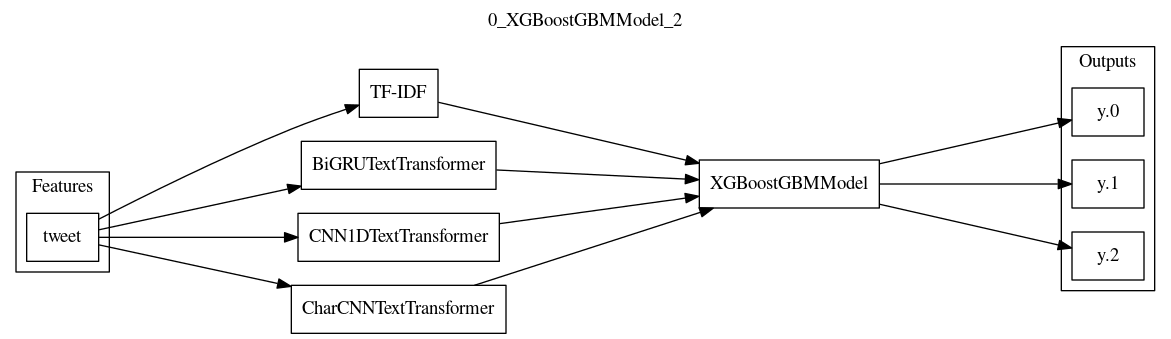

In [193]:
from PIL import Image
cwd = '/home/datasciprojects/jupyter/notebooks'
path = cwd+'/summary_Authority_Subversion/'
image = path+'0_XGBoostGBMModel_2.png'
img = Image.open(image)    # Open image as PIL image object
img

### Pipeline

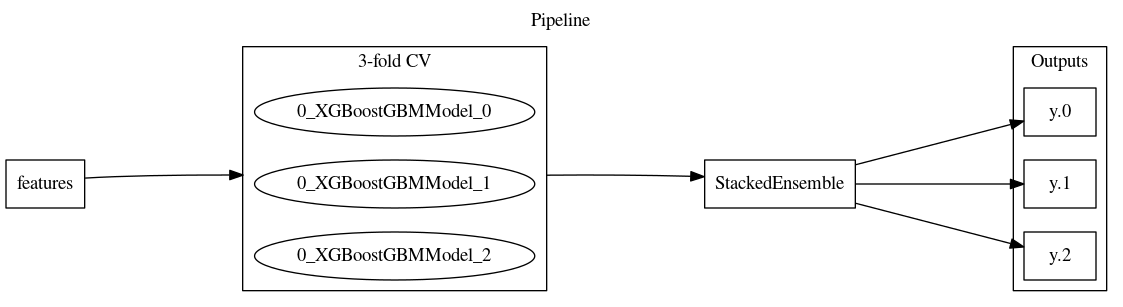

In [199]:
from PIL import Image
cwd = '/home/datasciprojects/jupyter/notebooks'
path = cwd+'/summary_Authority_Subversion/'
image = path+'pipeline.png'
img = Image.open(image)    # Open image as PIL image object
img

### Key Metrics
- Accuracy
- Confusion Matrix

In [200]:
key_metrics()

---- Care/Harm ----
Train Accuracy: 67 

 Confusion Matrix 
      TP   FP    
TP  399  211  FP
TN  131   49  FN
     TN   FN     



In [201]:
key_metrics(moralset='Authority/Subversion')

---- Authority/Subversion ----
Train Accuracy: 87 

 Confusion Matrix 
      TP   FP    
TP  687  103  FP
TN    0    0  FN
     TN   FN     



In [202]:
key_metrics(moralset='Fairness/Cheating')

---- Fairness/Cheating ----
Train Accuracy: 65 

 Confusion Matrix 
      TP   FP    
TP  374  234  FP
TN  142   40  FN
     TN   FN     



In [203]:
key_metrics(moralset='Loyalty/Betrayal')

---- Loyalty/Betrayal ----
Train Accuracy: 76 

 Confusion Matrix 
      TP   FP    
TP  561  179  FP
TN   38   12  FN
     TN   FN     



In [204]:
key_metrics(moralset='Purity/Degredation')

---- Purity/Degredation ----
Train Accuracy: 83 

 Confusion Matrix 
      TP   FP    
TP  650  133  FP
TN    7    0  FN
     TN   FN     

